# BEC and Thermal Cloud NN

## Imports

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
from generate_bec_thermal_cloud_nn_data import GenerateBecThermalCloudData
from matplotlib.colors import LogNorm

In [3]:
num_atoms = 100000
#calculate transition temperature

trans_temp = (num_atoms/(2*1*1.645))**0.5
print(trans_temp)

174.34201093860167


## Generate Training and Test Data

In [4]:
#training data size, test data size, noise spread, resolution length, number of atoms, transition temperature 

#current temps are {0:87,1:125,2:150,3:280}

#500 noise spread can get 98% accuracy
generate = GenerateBecThermalCloudData(10,5,0,100,100000,trans_temp)

--- 6.9141387939453125e-06 seconds ---
--- 0.3418571949005127 seconds ---


#### See What Data Images Look Like

0


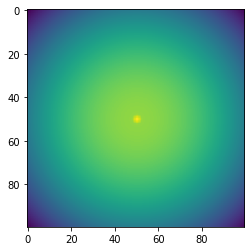

In [25]:
# T = 170
for i in range(len(generate.y_train)):
    if generate.y_train[i]==2:
        plt.imshow(generate.x_train[i],cmap = "viridis",norm = LogNorm())
        print(i)
        break

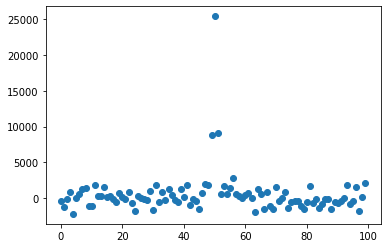

In [23]:
#plt.scatter(generate.x_train[0][0])
plt.scatter(np.arange(len(generate.x_train[0][0])),generate.x_train[3][50])

Text(0, 0.5, 'Atom Cloud Density')

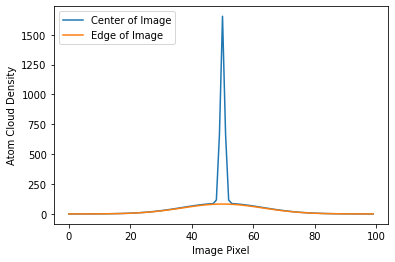

In [33]:
plt.plot(np.arange(len(generate.x_train[0][0])),generate.x_train[0][50],label = "Center of Image")
plt.plot(np.arange(len(generate.x_train[0][0])),generate.x_train[0][45],label = "Edge of Image")
plt.legend(loc='upper left')
plt.xlabel("Image Pixel")
plt.ylabel("Atom Cloud Density")

Text(0, 0.5, 'Number of Particles')

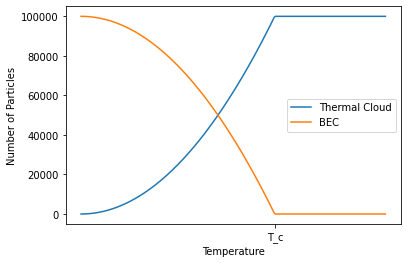

In [30]:
N=100000

def getN_ex(temp,trans_temp):
    if temp>=trans_temp:
        return N
    else:
        return N*(temp/trans_temp)**2
    
def getN_o(temp,trans_temp):
    if temp>=trans_temp:
        return 0
    else:
        return N*(1-(temp/trans_temp)**2)

temps=np.arange(trans_temp+100)

N_ex_arr = []
N_o_arr = []
for temp in temps:
    N_ex_arr.append(getN_ex(temp,trans_temp))
    N_o_arr.append(getN_o(temp,trans_temp))

plt.plot(temps,N_ex_arr,label="Thermal Cloud")
plt.plot(temps,N_o_arr,label = "BEC")
plt.legend(loc='center right')
x=[175]
labels = ['T_c']
plt.xticks(x, labels, rotation='horizontal')
plt.xlabel("Temperature")
plt.ylabel("Number of Particles")

## Compile Feed Forward NN

#### Basic NN

In [27]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200,activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(4,activation=tf.nn.softmax))

optim = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optim,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Metal device set to: Apple M2


2022-08-02 14:01:21.547847: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-02 14:01:21.548053: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Convolutional NN

In [28]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(kernel_size=3,filters=12,use_bias=False,padding='same'))
model.add(tf.keras.layers.BatchNormalization(center=True,scale=False))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Conv2D(kernel_size=6,filters=24,use_bias=False,padding='same',strides=2))
model.add(tf.keras.layers.BatchNormalization(center=True,scale=False))
model.add(tf.keras.layers.Activation("relu"))


model.add(tf.keras.layers.Conv2D(kernel_size=6,filters=32,use_bias=False,padding='same',strides=2))
model.add(tf.keras.layers.BatchNormalization(center=True,scale=False))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(200,use_bias=False))
model.add(tf.keras.layers.BatchNormalization(center=True,scale=False))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(4,activation=tf.nn.softmax))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=["accuracy"])

x_train = np.asarray(generate.x_train)
x_test = np.asarray(generate.x_test)

x_test = x_test.reshape((x_test.shape[0], 100, 100, 1)).tolist()
x_train = x_train.reshape((x_train.shape[0], 100, 100, 1)).tolist()

## Train Model

In [29]:
model.fit(x_train,generate.y_train,epochs=32)

Epoch 1/32


2022-08-02 14:01:56.366977: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-02 14:01:56.711626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 51ms/step - loss: 0.1527 - accuracy: 0.9480
Epoch 2/32
32/32 [==============================] - 2s 48ms/step - loss: 0.0132 - accuracy: 0.9980
Epoch 3/32
32/32 [==============================] - 2s 48ms/step - loss: 0.0343 - accuracy: 0.9920
Epoch 4/32
32/32 [==============================] - 2s 47ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 5/32
32/32 [==============================] - 2s 47ms/step - loss: 0.0076 - accuracy: 1.0000
Epoch 6/32
32/32 [==============================] - 2s 47ms/step - loss: 7.6040e-04 - accuracy: 1.0000
Epoch 7/32
32/32 [==============================] - 2s 49ms/step - loss: 0.0045 - accuracy: 0.9980
Epoch 8/32
32/32 [==============================] - 2s 47ms/step - loss: 0.0462 - accuracy: 0.9860
Epoch 9/32
32/32 [==============================] - 2s 48ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 10/32
32/32 [==============================] - 2s 47ms/step - loss: 8.6988e-04 - accuracy: 1.0000
Epoch 11/32


## Evaluate Results

In [30]:
val_loss, val_acc = model.evaluate(generate.x_test,generate.y_test)
print("loss: ",val_loss,"\n","accuracy: ",val_acc)

11/16 [===================>..........] - ETA: 0s - loss: 3.4493e-06 - accuracy: 1.0000

2022-08-02 14:02:54.526878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 0s 12ms/step - loss: 3.3878e-06 - accuracy: 1.0000
loss:  3.3878131944220513e-06 
 accuracy:  1.0
